В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
import warnings

In [2]:
raw_df = pd.read_csv("train.csv", index_col=0)

In [3]:
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

In [4]:
# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

In [5]:
# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()  
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

numeric_cols, categorical_cols

(['CreditScore',
  'Age',
  'Tenure',
  'Balance',
  'NumOfProducts',
  'HasCrCard',
  'IsActiveMember',
  'EstimatedSalary'],
 ['Surname', 'Geography', 'Gender'])

In [6]:
train_inputs.drop(columns=['Surname'], inplace=True)
val_inputs.drop(columns=['Surname'], inplace=True)

In [7]:
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()
categorical_cols

['Geography', 'Gender']

In [9]:
# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

In [10]:
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [11]:
# Комбінуємо трансформери для різних типів колонок в один препроцесор
# Параметр transformers - це список, де кожен елемент має формат: ім'я_трансформера, об’єкт_трансформера, список_колонок
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [12]:
# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуємо модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [13]:
# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                         

In [14]:
# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}%".format(f1))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

F1 score: 0.64%


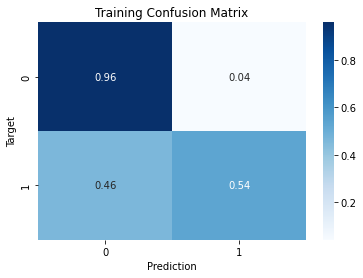

F1 score: 0.64%


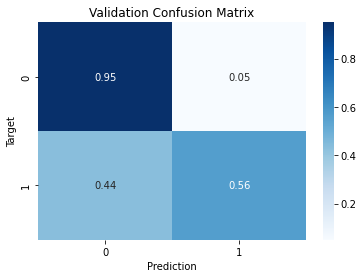

In [15]:
# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(train_inputs, train_targets, 'Training')
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')

In [16]:
def compute_auroc_and_build_roc(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model_pipeline.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.88


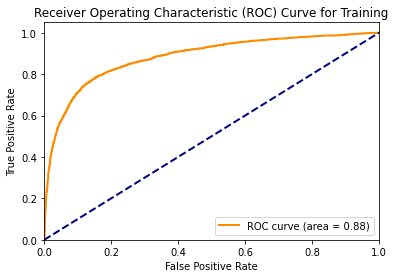

AUROC for Validation: 0.88


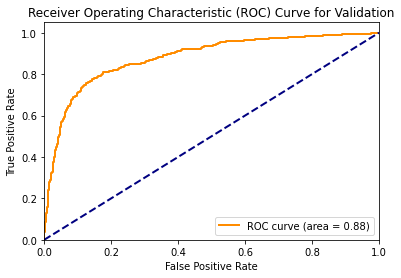

In [17]:
compute_auroc_and_build_roc(train_inputs, train_targets, 'Training')
compute_auroc_and_build_roc(val_inputs, val_targets, 'Validation')

In [18]:
# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'churn_rate.joblib')

['churn_rate.joblib']

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [19]:
numeric_transformer_poly2 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler())
])

In [20]:
preprocessor_poly2 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly2, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [21]:
model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly2),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [22]:
# Навчання
model_pipeline_poly2.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                               

In [23]:
# Функція, щоб передбачати і рахувати метрики
def predict_and_plot_poly2(inputs, targets, name=''):
    preds = model_pipeline_poly2.predict(inputs)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}%".format(f1))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

F1 score: 0.68%


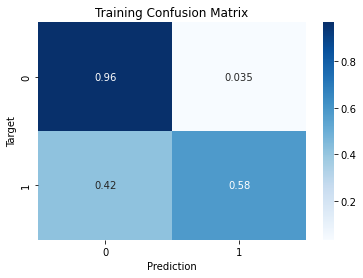

F1 score: 0.68%


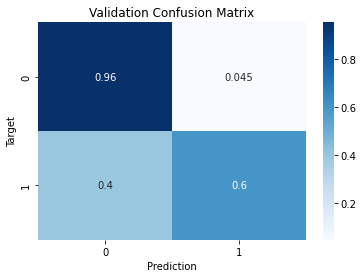

In [24]:
# Оцінюємо модель на трен і вал даних
train_preds_poly2 = predict_and_plot_poly2(train_inputs, train_targets, 'Training')
val_preds_poly2 = predict_and_plot_poly2(val_inputs, val_targets, 'Validation')

In [25]:
def compute_auroc_and_build_roc_poly2(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model_pipeline_poly2.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.91


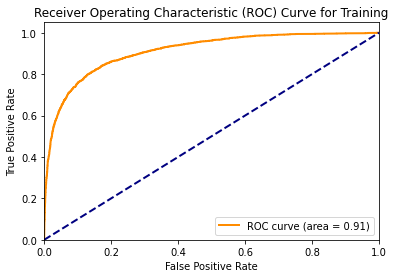

AUROC for Validation: 0.91


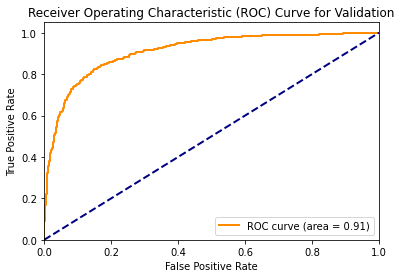

In [26]:
compute_auroc_and_build_roc_poly2(train_inputs, train_targets, 'Training')
compute_auroc_and_build_roc_poly2(val_inputs, val_targets, 'Validation')

<span style="color:green"> F1 і Auroc мають практично однакові значенняна train і val наборах, це означає, що модель не перенавчається і добре генералізує - тобто вона ефективно застосовує знання, отримані під час навчання на тренувальних даних, до нових, валідаційних даних.Також показники F1 і Auroc підросли, що означає, що модель стала кращою. </span> 

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [27]:
numeric_transformer_poly4 = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', MinMaxScaler())
])

In [28]:
preprocessor_poly4 = ColumnTransformer(transformers=[
    ('num', numeric_transformer_poly4, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear'))
])
# Навчання
model_pipeline_poly4.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                            

In [29]:
# Функція, щоб передбачати і рахувати метрики
def predict_and_plot_poly4(inputs, targets, name=''):
    preds = model_pipeline_poly4.predict(inputs)
    f1 = f1_score(targets, preds, pos_label=1)
    print("F1 score: {:.2f}%".format(f1))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

F1 score: 0.71%


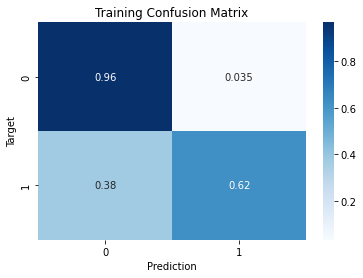

F1 score: 0.70%


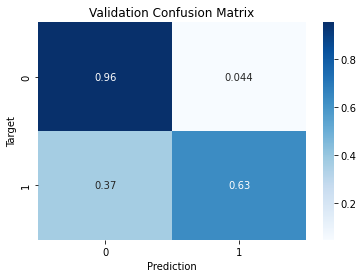

In [30]:
# Оцінюємо модель на трен і вал даних
train_preds_poly4 = predict_and_plot_poly4(train_inputs, train_targets, 'Training')
val_preds_poly4 = predict_and_plot_poly4(val_inputs, val_targets, 'Validation')

In [31]:
def compute_auroc_and_build_roc_poly4(inputs, targets, name=''):
  # Predict probabilities
  y_pred_proba = model_pipeline_poly4.predict_proba(inputs)[:, 1]

  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

    # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

AUROC for Training: 0.93


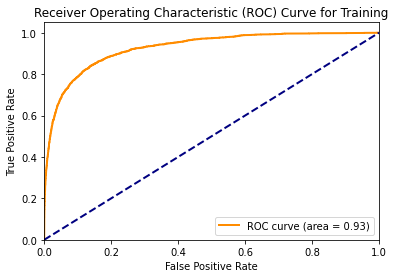

AUROC for Validation: 0.92


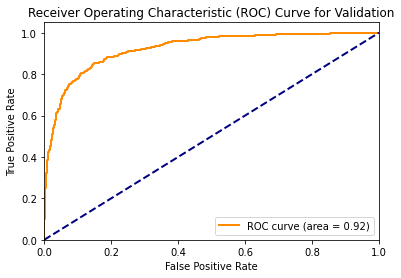

In [32]:
compute_auroc_and_build_roc_poly4(train_inputs, train_targets, 'Training')
compute_auroc_and_build_roc_poly4(val_inputs, val_targets, 'Validation')

<span style="color:green"> F1 і Auroc в цьому випадку також мають значення близькі на train і val наборах, тобто модель не перенавчається і добре генералізує. Показники F1 і Auroc підросли ще більше - це означає, що модель стала ще кращою. Однак, модель все ще погано прогнозує клас 1, тому можна сказати, що вона недонавчена через незбалансованість класів. </span> 

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [33]:
data = pd.read_csv("regression_data.csv")
data.head(3)

,feature_1,feature_2,feature_3,feature_4,feature_5,target
0,-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
1,-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2,2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482


In [36]:
#Перевіримо які характеристики впливають на таргет. Видно, що feature_4 майже стовідсотково корелює з таргетом. 
correlations = data.corr()
target_corr = correlations['target'].sort_values(ascending=False)
print(target_corr)

target       1.000000
feature_4    0.999734
feature_1    0.007453
feature_3   -0.042851
feature_2   -0.049995
feature_5   -0.155143
Name: target, dtype: float64


In [37]:
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

In [38]:
input_cols = list(train_df.columns)[0:-1]

In [40]:
target_col = 'target'

In [51]:
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()

In [56]:
numeric_transformer_lr = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=1, include_bias=False)),
    ('scaler', StandardScaler())
])
preprocessor_lr = ColumnTransformer(transformers=[
    ('num', numeric_transformer_lr, input_cols),
])
model_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor_lr),
    ('regressor', LinearRegression())
])
# Навчання
model_pipeline_lr.fit(train_inputs, train_targets)
val_predictions = model_pipeline_lr.predict(val_inputs)

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mse = mean_squared_error(val_targets, val_predictions)
rmse = root_mean_squared_error (val_targets, val_predictions)  
mae = mean_absolute_error(val_targets, val_predictions)
r2 = r2_score(val_targets, val_predictions)

print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}")

MSE: 0.7802672534843738, RMSE: 0.8833273761660361, MAE: 0.7504646549909781, R²: 0.999665561359872


In [94]:
print(f"Linear regression:")

degrees = range(1, 6)

for deg in degrees:
    numeric_transformer_lr = Pipeline([
    ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
    ('scaler', StandardScaler())])  
    
    preprocessor_lr = ColumnTransformer([
    ('num', numeric_transformer_lr, input_cols)])
    
    
    model_pipeline_lr = Pipeline([
        ('preprocessor', preprocessor_lr),
        ('regressor', LinearRegression())
    ])

    model_pipeline_lr.fit(train_inputs, train_targets)
    val_predictions = model_pipeline_lr.predict(val_inputs)

    mse = mean_squared_error(val_targets, val_predictions)
    rmse = root_mean_squared_error(val_targets, val_predictions)
    mae = mean_absolute_error(val_targets, val_predictions)
    r2 = r2_score(val_targets, val_predictions)
    print(f"Degree {deg} | MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Linear regression:
Degree 1 | MSE: 0.7803, RMSE: 0.8833, MAE: 0.7505, R2: 0.9997
Degree 2 | MSE: 1.0299, RMSE: 1.0149, MAE: 0.9102, R2: 0.9996
Degree 3 | MSE: 3.6709, RMSE: 1.9160, MAE: 1.4993, R2: 0.9984
Degree 4 | MSE: 159.0654, RMSE: 12.6121, MAE: 9.2247, R2: 0.9318
Degree 5 | MSE: 160.0566, RMSE: 12.6513, MAE: 8.0748, R2: 0.9314


<span style="color:green"> З отриманих даних можемо зробити висновок, що модель в ступені 1 є найоптимальнішою - вона найбільш точна (R2: 0.9997) і має найменшу кількість помилок (найнижчий RMSE). Модель 5 ступеню все ще має достатньо високий R2, але набагато більшу кількість помилок. </span>

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [95]:
print(f"Ridge regression:")

degrees = range(1, 21)

for deg in degrees:
    
    numeric_transformer_lr = Pipeline([
    ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
    ('scaler', StandardScaler())])  
    
    preprocessor_lr = ColumnTransformer([
    ('num', numeric_transformer_lr, input_cols)])
    
       
    model_pipeline_ridge = Pipeline([
        ('preprocessor', preprocessor_lr),
        ('regressor', Ridge(alpha=0.03))
    ])

    model_pipeline_ridge.fit(train_inputs, train_targets)
    val_predictions = model_pipeline_ridge.predict(val_inputs)

    mse = mean_squared_error(val_targets, val_predictions)
    rmse = root_mean_squared_error(val_targets, val_predictions)
    mae = mean_absolute_error(val_targets, val_predictions)
    r2 = r2_score(val_targets, val_predictions)
    print(f"Degree {deg} | MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Ridge regression:
Degree 1 | MSE: 0.7764, RMSE: 0.8812, MAE: 0.7477, R2: 0.9997
Degree 2 | MSE: 1.0297, RMSE: 1.0147, MAE: 0.9090, R2: 0.9996
Degree 3 | MSE: 4.0552, RMSE: 2.0138, MAE: 1.5627, R2: 0.9983
Degree 4 | MSE: 174.4289, RMSE: 13.2072, MAE: 7.5782, R2: 0.9252
Degree 5 | MSE: 150.8301, RMSE: 12.2813, MAE: 8.3492, R2: 0.9354
Degree 6 | MSE: 280.7401, RMSE: 16.7553, MAE: 10.6435, R2: 0.8797
Degree 7 | MSE: 287.8301, RMSE: 16.9656, MAE: 10.7079, R2: 0.8766
Degree 8 | MSE: 383.4474, RMSE: 19.5818, MAE: 11.9945, R2: 0.8356
Degree 9 | MSE: 414.3362, RMSE: 20.3552, MAE: 13.1167, R2: 0.8224
Degree 10 | MSE: 442.8666, RMSE: 21.0444, MAE: 13.0697, R2: 0.8102
Degree 11 | MSE: 778.3531, RMSE: 27.8990, MAE: 16.0886, R2: 0.6664
Degree 12 | MSE: 467.7278, RMSE: 21.6270, MAE: 13.2675, R2: 0.7995
Degree 13 | MSE: 1615.2862, RMSE: 40.1906, MAE: 19.3592, R2: 0.3077
Degree 14 | MSE: 506.9478, RMSE: 22.5155, MAE: 14.0724, R2: 0.7827
Degree 15 | MSE: 2644.3734, RMSE: 51.4235, MAE: 21.9732, R2: -0.13

In [96]:
print(f"Lasso regression:")

degrees = range(1, 21)

for deg in degrees:
    numeric_transformer_lr = Pipeline([
        ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
        ('scaler', StandardScaler())
    ])
    
    preprocessor_lr = ColumnTransformer([
        ('num', numeric_transformer_lr, input_cols)
    ])

    model_pipeline_lasso = Pipeline([
        ('preprocessor', preprocessor_lr),
        ('regressor', Lasso(alpha=0.05))
    ])

    model_pipeline_lasso.fit(train_inputs, train_targets)
    val_predictions = model_pipeline_lasso.predict(val_inputs)

    mse = mean_squared_error(val_targets, val_predictions)
    rmse = root_mean_squared_error(val_targets, val_predictions)
    mae = mean_absolute_error(val_targets, val_predictions)
    r2 = r2_score(val_targets, val_predictions)
    
    print(f"Degree {deg} | MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Lasso regression:
Degree 1 | MSE: 0.7338, RMSE: 0.8566, MAE: 0.7152, R2: 0.9997
Degree 2 | MSE: 0.8278, RMSE: 0.9098, MAE: 0.7824, R2: 0.9996
Degree 3 | MSE: 0.8673, RMSE: 0.9313, MAE: 0.7929, R2: 0.9996
Degree 4 | MSE: 0.9821, RMSE: 0.9910, MAE: 0.8458, R2: 0.9996
Degree 5 | MSE: 1.0036, RMSE: 1.0018, MAE: 0.8209, R2: 0.9996
Degree 6 | MSE: 0.9575, RMSE: 0.9785, MAE: 0.8030, R2: 0.9996
Degree 7 | MSE: 1.0210, RMSE: 1.0104, MAE: 0.8164, R2: 0.9996
Degree 8 | MSE: 0.7635, RMSE: 0.8738, MAE: 0.7349, R2: 0.9997
Degree 9 | MSE: 0.7836, RMSE: 0.8852, MAE: 0.7418, R2: 0.9997
Degree 10 | MSE: 0.7747, RMSE: 0.8802, MAE: 0.7395, R2: 0.9997
Degree 11 | MSE: 0.8208, RMSE: 0.9060, MAE: 0.7558, R2: 0.9996
Degree 12 | MSE: 0.8202, RMSE: 0.9057, MAE: 0.7556, R2: 0.9996
Degree 13 | MSE: 0.8359, RMSE: 0.9143, MAE: 0.7625, R2: 0.9996
Degree 14 | MSE: 0.8316, RMSE: 0.9119, MAE: 0.7610, R2: 0.9996
Degree 15 | MSE: 0.8292, RMSE: 0.9106, MAE: 0.7595, R2: 0.9996
Degree 16 | MSE: 0.8314, RMSE: 0.9118, MAE: 0.

In [117]:
print(f"ElasticNet regression:")

degrees = range(1, 21)

for deg in degrees:
    numeric_transformer_lr = Pipeline([
        ('poly', PolynomialFeatures(degree=deg, include_bias=False)),
        ('scaler', StandardScaler())
    ])
    
    preprocessor_lr = ColumnTransformer([
        ('num', numeric_transformer_lr, input_cols)
    ])

    model_pipeline_elastic = Pipeline([
        ('preprocessor', preprocessor_lr),
        ('regressor', ElasticNet(alpha=0.005, l1_ratio=1.0, max_iter=50000, tol=1e-3))
    ])

    model_pipeline_elastic.fit(train_inputs, train_targets)
    val_predictions = model_pipeline_elastic.predict(val_inputs)

    mse = mean_squared_error(val_targets, val_predictions)
    rmse = root_mean_squared_error(val_targets, val_predictions)
    mae = mean_absolute_error(val_targets, val_predictions)
    r2 = r2_score(val_targets, val_predictions)
    print(f"Degree {deg} | MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

ElasticNet regression:
Degree 1 | MSE: 0.7743, RMSE: 0.8799, MAE: 0.7470, R2: 0.9997
Degree 2 | MSE: 1.0352, RMSE: 1.0174, MAE: 0.9088, R2: 0.9996
Degree 3 | MSE: 3.0153, RMSE: 1.7365, MAE: 1.4498, R2: 0.9987
Degree 4 | MSE: 3.4911, RMSE: 1.8685, MAE: 1.5774, R2: 0.9985
Degree 5 | MSE: 4.3975, RMSE: 2.0970, MAE: 1.7264, R2: 0.9981
Degree 6 | MSE: 4.4650, RMSE: 2.1130, MAE: 1.7459, R2: 0.9981
Degree 7 | MSE: 5.1374, RMSE: 2.2666, MAE: 1.8247, R2: 0.9978
Degree 8 | MSE: 5.5734, RMSE: 2.3608, MAE: 1.8689, R2: 0.9976
Degree 9 | MSE: 6.9021, RMSE: 2.6272, MAE: 1.9686, R2: 0.9970
Degree 10 | MSE: 6.9774, RMSE: 2.6415, MAE: 1.9716, R2: 0.9970
Degree 11 | MSE: 6.6991, RMSE: 2.5883, MAE: 1.9516, R2: 0.9971
Degree 12 | MSE: 6.5163, RMSE: 2.5527, MAE: 1.9399, R2: 0.9972
Degree 13 | MSE: 5.9385, RMSE: 2.4369, MAE: 1.8996, R2: 0.9975
Degree 14 | MSE: 6.3110, RMSE: 2.5122, MAE: 1.9275, R2: 0.9973
Degree 15 | MSE: 6.0995, RMSE: 2.4697, MAE: 1.9141, R2: 0.9974
Degree 16 | MSE: 6.1080, RMSE: 2.4714, MA

In [126]:
ridge_model = model_pipeline_ridge.named_steps['regressor']
lasso_model = model_pipeline_lasso.named_steps['regressor']
elastic_model = model_pipeline_elastic.named_steps['regressor']

ridge_coefs = ridge_model.coef_.ravel()
lasso_coefs = lasso_model.coef_.ravel()
elasticnet_coefs = elastic_model.coef_.ravel()

ridge_intercept = ridge_model.intercept_
lasso_intercept = lasso_model.intercept_
elasticnet_intercept = elastic_model.intercept_

# 2. Сортуємо ознаки за абсолютним значенням коефіцієнтів Ridge (для прикладу)
# Щоб обрати іншу модель для сортування, змініть ridge_coefs на відповідну змінну
sorted_indices = np.argsort(np.abs(ridge_coefs))[::-1]

# Застосовуємо сортування до всіх коефіцієнтів та назв ознак
ridge_coefs = ridge_coefs[sorted_indices]
lasso_coefs = lasso_coefs[sorted_indices]
elasticnet_coefs = elasticnet_coefs[sorted_indices]
sorted_input_cols = [input_cols[i] for i in sorted_indices]

# 3. Виведемо таблицю з коефіцієнтами та перехопленнями в консоль (для наочності)
df_coefs = pd.DataFrame({
    'Feature': sorted_input_cols,
    'Lasso': lasso_coefs,
    'Ridge': ridge_coefs,
    'ElasticNet': elasticnet_coefs
})
print("Коефіцієнти моделей:")
print(df_coefs)

Коефіцієнти моделей:
     Feature      Lasso      Ridge  ElasticNet
0  feature_4  44.064788  44.103329   43.610293
1  feature_5  -0.132903  -0.189452    0.030698
2  feature_1   0.091016   0.149935   -0.990408
3  feature_3   0.000000   0.042659   -1.326089
4  feature_2  -0.000000  -0.001645    0.046684


<span style="color:green"> Висновки:
Модель ступеня 1 (як у лінійній регресії, так і в її регуляризованих версіях) демонструє дуже хороші результати. Різниці між моделями дуже невеликі через те, що дані мають домінуючу ознаку (feature_4) з дуже високою кореляцією з цільовою змінною. 
При порівнянні моделей за їхніми основними метриками модель Lasso показує найкращі результати (найвищий R2  і найнижчі показники помилок). Оскільки Lasso може обнуляти деякі коефіцієнти (в даному випадку для feature_3 та feature_2) за рахунок використання першої норми, а не другої (як Ridge), вона найефективніше виділяє найважливішу ознаку (feature_4) і мінімізує вплив шуму від інших ознак. </span>